## Code produit avec l'article: 
https://medium.com/h7w/implementing-a-variational-autoencoder-with-keras-e19d7140ad90

## On entraîne le modèle sur tous les pixels
### Permet de visualiser les dimensions de la carte latente

In [29]:
from keras.layers import Conv1D, Conv2D, Input, Flatten, Dense, MaxPooling1D, MaxPooling2D, BatchNormalization, Concatenate, Reshape, Conv2DTranspose, Lambda
from sklearn.model_selection import train_test_split
from tensorflow.keras import backend as K
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from keras.optimizers import Adam
import matplotlib.pyplot as plt
from keras.models import Model
from tensorflow import keras
from keras import layers
import tensorflow as tf
from PIL import Image
import copy
import numpy as np
import os
import re

In [2]:
# Fonction pour calculer les coordonées stéréographiques

def stereo(theta, phi):
    x = np.sin(theta) * np.cos(phi)
    y = np.sin(theta) * np.sin(phi)
    z = np.cos(theta)

    # Projection sur x y
    px = x / (1 + z + 1e-8)
    py = y / (1 + z + 1e-8)
    return px, py

# Importation des images

In [3]:
# Dossier contenant les images
repertoire = "../Render/captures"
img_width, img_height = 30, 30

# Expression pour extraire les infos du nom de fichier
#pattern = re.compile(r"img_tv(\d+)_pv(\d+)_tl(\d+)_pl(\d+)\.png") #all
pattern = re.compile(r"img_tv0_pv0_tl(\d+)_pl(\d+)\.png") #les images avec tv = 45 (la latitude moyenne)

# Stockage des résultats
images_info = []

for nom_fichier in os.listdir(repertoire):
    if nom_fichier.endswith(".png"):
        match = pattern.match(nom_fichier)
        if match:
            tl, pl = match.groups()
            tl, pl = int(tl), int(pl)
            px, py = stereo(np.radians(tl), np.radians(pl)) # Calcul des coordonnées stéréo
            chemin_image = os.path.join(repertoire, nom_fichier)
            image = Image.open(chemin_image)
            w, h = image.size
            left = (w - img_width) / 2
            top = (h - img_height) / 2
            right = (w + img_width) / 2
            bottom = (h + img_height) / 2
            #left, top, right, bottom = int(left), int(top), int(right), int(bottom)
            image = Image.open(chemin_image).convert("RGB").crop((left, top, right, bottom))
            pixels = np.array(image, dtype=np.float32) / 255.0



            images_info.append({
                "tl": tl,
                "pl": pl,
                "px": px,
                "py": py,
                "image": image,
                "pixels": pixels,
            })

# Exemple : affichage d'une info
for info in images_info[:5]:  # juste les 5 premières
    print(f"tl={info['tl']}, pl={info['pl']}, px={info['px']}, py={info['py']}")

tl=75, pl=345, px=0.7411809490095723, py=-0.198598836732448
tl=60, pl=252, px=-0.17841104369713806, py=-0.5490927320369364
tl=75, pl=225, px=-0.5425821122771244, py=-0.5425821122771243
tl=30, pl=120, px=-0.13397459549759358, py=0.23205080632532074
tl=45, pl=0, px=0.4142135599466882, py=0.0


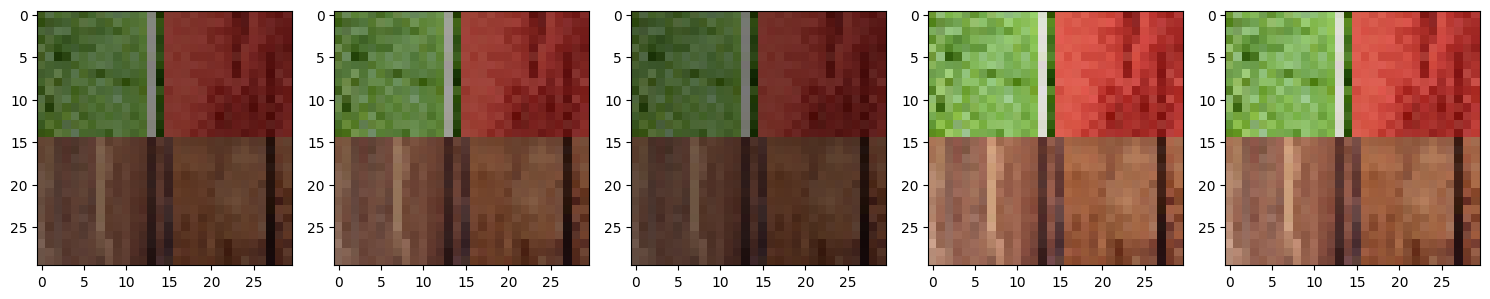

In [4]:
fig, axes = plt.subplots(1, 5, figsize=(15, 5))
for i in range(5): axes[i].imshow(images_info[i]['pixels'])
plt.tight_layout()
plt.show()

# On trie la liste

In [5]:
sorted = copy.deepcopy(images_info)
sorted.sort(key=lambda d: (d["tl"], d["pl"]))

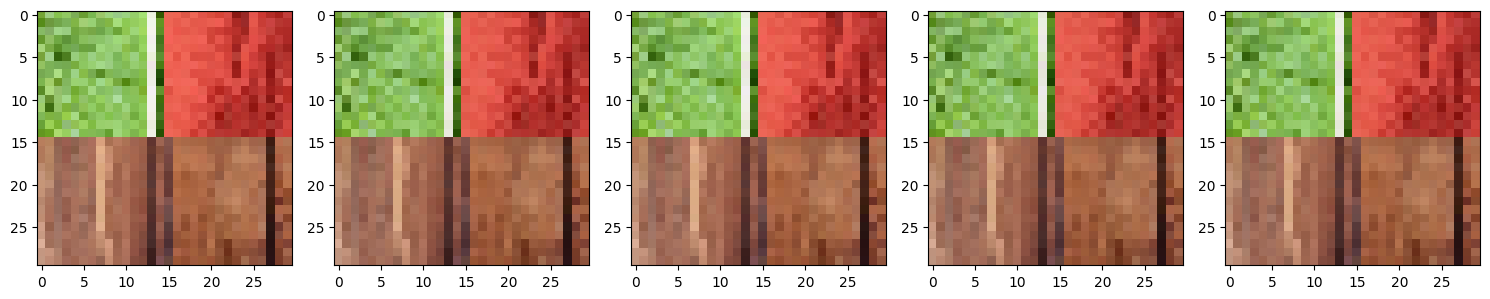

In [6]:
fig, axes = plt.subplots(1, 5, figsize=(15, 5))
for i in range(5): axes[i].imshow(sorted[i]['pixels'])
plt.tight_layout()
plt.show()

In [7]:
print("Premier pixel de la troisième image (R,G,B) :", images_info[2]['pixels'][0][0])
print("Nombre d'images importées:", len(images_info))

Premier pixel de la troisième image (R,G,B) : [0.22352941 0.3137255  0.10196079]
Nombre d'images importées: 81


# Création du modèles

In [8]:
# Paramètres du Modèle et des Données
num_channels = 3 # RGB
latent_dim = 3
N_angles_categories = samples = len(images_info) # Nombre de configuration angulaires

# Poids pour la fonction de perte CL-VAE
gamma = 0.3
beta = 1.0

# Input shape pour les images
input_shape_image = (img_width, img_height, num_channels)

# =================================================================
# 1. Encodeur (CL-VAE) - Prend l'image et la catégorie d'angle en entrée
# =================================================================

# Entrée pour l'image
x_input = Input(shape=input_shape_image, name='image_input')

# Entrée pour la catégorie d'angle de lumière (one-hot encoded)
y_input = Input(shape=(N_angles_categories,), name='angle_category_input')


# Bloc de convolutions 2D pour l'image
x = Conv2D(filters=32, kernel_size=3, strides=2, padding='same', activation='relu')(x_input) # Réduit la dimension (15x15)
x = BatchNormalization()(x)

x = Conv2D(filters=64, kernel_size=3, strides=2, padding='same', activation='relu')(x)      # Réduit la dimension (8x8 ou 7x7)
x = BatchNormalization()(x)

x = Conv2D(filters=128, kernel_size=3, strides=2, padding='same', activation='relu')(x)     # Réduit la dimension (4x4 ou 3x3)
x = BatchNormalization()(x)


# Sauvegarder la forme avant d'aplatir pour le décodeur
shape_before_flattening = K.int_shape(x)[1:] # Ex: (4, 4, 128) ou (3, 3, 128)
flattened_image_features = Flatten()(x)


# C'est ici que l'information de la catégorie d'angle est injectée pour conditionner le mu et log_var
combined_features = Concatenate(name='combined_features_encoder')([flattened_image_features, y_input])

# Couches denses pour calculer mu (moyenne) et log_var (log-variance) de l'espace latent
mu = Dense(latent_dim, name='z_mean')(combined_features)
log_var = Dense(latent_dim, name='z_log_var')(combined_features)

# Re-parameterization trick (échantillonnage de z)
def sampling(args):
    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

z = Lambda(sampling, output_shape=(latent_dim,), name='z')([mu, log_var])

# Modèle Encodeur
encoder = Model(inputs=[x_input, y_input], outputs=[mu, log_var, z], name="Encoder_CLVAE")
encoder.summary()

Model: "Encoder_CLVAE"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ image_input         │ (None, 30, 30, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 15, 15,    │        896 │ image_input[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 15, 15,    │        128 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 8, 8, 64)  │     18,496 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 8, 8, 64)  │        256 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 4, 4, 128) │     73,856 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 4, 4, 128) │        512 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 2048)      │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ angle_category_inp… │ (None, 81)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ combined_features_… │ (None, 2129)      │          0 │ flatten[0][0],    │
│ (Concatenate)       │                   │            │ angle_category_i… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_mean (Dense)      │ (None, 3)         │      6,390 │ combined_feature… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_log_var (Dense)   │ (None, 3)         │      6,390 │ combined_feature… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z (Lambda)          │ (None, 3)         │          0 │ z_mean[0][0],     │
│                     │                   │            │ z_log_var[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 106,924 (417.67 KB)

 Trainable params: 106,476 (415.92 KB)

 Non-trainable params: 448 (1.75 KB)

In [9]:

# =================================================================
# 2. Décodeur (CL-VAE) - Prend le vecteur latent et la catégorie d'angle en entrée
# =================================================================

# Entrée pour le vecteur latent
z_input = Input(shape=(latent_dim,), name='z_input_decoder')

# Entrée pour la catégorie d'angle de lumière (one-hot encoded)
y_input_decoder = Input(shape=(N_angles_categories,), name='angle_category_input_decoder')


# Fusion du vecteur latent et de la catégorie d'angle pour la génération
decoder_combined_input = Concatenate(name='combined_features_decoder')([z_input, y_input_decoder])


# Couches denses pour "décompresser" le vecteur combiné
x_decoder = Dense(np.prod(shape_before_flattening), activation='relu')(decoder_combined_input)
x_decoder = Reshape(shape_before_flattening)(x_decoder)


# Bloc de convolutions 2D transposées pour générer l'image
x_decoder = Conv2DTranspose(filters=128, kernel_size=3, strides=2, padding='same', activation='relu')(x_decoder) # Remonte la dimension
x_decoder = BatchNormalization()(x_decoder)

x_decoder = Conv2DTranspose(filters=64, kernel_size=3, strides=2, padding='same', activation='relu')(x_decoder)   # Remonte la dimension
x_decoder = BatchNormalization()(x_decoder)

x_decoder = Conv2DTranspose(filters=32, kernel_size=3, strides=2, padding='same', activation='relu')(x_decoder)   # Remonte la dimension
x_decoder = BatchNormalization()(x_decoder)


# Couche de sortie: RGB, donc 3 canaux, activation sigmoïde pour des pixels entre 0 et 1
# La taille de la sortie doit correspondre à l'entrée originale de l'encodeur
reconstruction_output = Conv2D(filters=num_channels, kernel_size=3, padding='same', activation='sigmoid', name='reconstruction_output')(x_decoder)


# Assurez-vous que la forme de sortie du décodeur correspond à la forme d'entrée originale (width, height)
# Il peut y avoir un léger décalage si les strides ne divisent pas parfaitement.
# Nous ajoutons une couche de Recalage/Cropping si nécessaire pour matcher la taille originale.
# K.int_shape(reconstruction_output) peut être (None, 32, 32, 3) pour une entrée 30x30
if K.int_shape(reconstruction_output)[1] != img_width or K.int_shape(reconstruction_output)[2] != img_height:
    # Calculer le padding/cropping nécessaire pour atteindre la taille exacte
    diff_w = K.int_shape(reconstruction_output)[1] - img_width
    diff_h = K.int_shape(reconstruction_output)[2] - img_height
    # Assurez-vous que diff_w et diff_h sont positifs et pairs pour un cropping symétrique
    if diff_w > 0 or diff_h > 0:
        cropping_w = diff_w // 2
        cropping_h = diff_h // 2
        # tf.keras.layers.Cropping2D prend (top_crop, bottom_crop), (left_crop, right_crop)
        reconstruction_output = layers.Cropping2D(
            cropping=((cropping_h, diff_h - cropping_h), (cropping_w, diff_w - cropping_w))
        )(reconstruction_output)
    elif diff_w < 0 or diff_h < 0:
        # Si la sortie est trop petite, c'est une erreur de conception de stride ou padding
        print(f"Warning: Decoder output is smaller than target. Output: {K.int_shape(reconstruction_output)}, Target: ({img_width}, {img_height}, {num_channels})")
        # Une solution simple pour l'exemple, mais à ajuster précisément pour votre cas
        reconstruction_output = tf.image.resize(reconstruction_output, (img_height, img_width), method='nearest') # nearest_neighbor pour les images

decoder = Model(inputs=[z_input, y_input_decoder], outputs=reconstruction_output, name="Decoder_CLVAE")
decoder.summary()

Model: "Decoder_CLVAE"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ z_input_decoder     │ (None, 3)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ angle_category_inp… │ (None, 81)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ combined_features_… │ (None, 84)        │          0 │ z_input_decoder[… │
│ (Concatenate)       │                   │            │ angle_category_i… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 2048)      │    174,080 │ combined_feature… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 4, 4, 128) │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose    │ (None, 8, 8, 128) │    147,584 │ reshape[0][0]     │
│ (Conv2DTranspose)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 8, 8, 128) │        512 │ conv2d_transpose… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_1  │ (None, 16, 16,    │     73,792 │ batch_normalizat… │
│ (Conv2DTranspose)   │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16, 16,    │        256 │ conv2d_transpose… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_2  │ (None, 32, 32,    │     18,464 │ batch_normalizat… │
│ (Conv2DTranspose)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        128 │ conv2d_transpose… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reconstruction_out… │ (None, 32, 32, 3) │        867 │ batch_normalizat… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cropping2d          │ (None, 30, 30, 3) │          0 │ reconstruction_o… │
│ (Cropping2D)        │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 415,683 (1.59 MB)

 Trainable params: 415,235 (1.58 MB)

 Non-trainable params: 448 (1.75 KB)

In [10]:
# =================================================================
# 3. Modèle Auto-Encodeur CL-VAE Complet avec Perte Personnalisée
# =================================================================

# Entrées du modèle complet (les mêmes que pour l'encodeur)
autoencoder_x_input = Input(shape=input_shape_image, name='autoencoder_image_input')
autoencoder_y_input = Input(shape=(N_angles_categories,), name='autoencoder_angle_category_input')

# --- Création du Modèle Keras avec la Perte Personnalisée ---
class CLVAE(Model):
    def __init__(self, encoder, decoder, N_angles_categories, latent_dim, gamma, beta, **kwargs):
        super(CLVAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.gamma = gamma
        self.beta = beta
        # Définir mu_priors comme une variable du modèle CLVAE pour qu'elle soit entraînable
        self.mu_priors = tf.Variable(tf.random.normal(shape=(N_angles_categories, latent_dim), stddev=0.1), trainable=True, name='mu_priors')

    def call(self, inputs):
        x, y_category = inputs
        z_mean, z_log_var, z = self.encoder([x, y_category])
        reconstruction = self.decoder([z, y_category])

        # Calculer les pertes en utilisant tf.keras.ops
        # 1. Perte de Reconstruction (MSE)
        reconstruction_loss = K.mean(K.square(x - reconstruction), axis=[1, 2, 3]) # Moyenne sur H, W, C

        # 2. Terme de Divergence KL Conditionnelle
        # Récupérer la moyenne a priori pour la catégorie d'angle actuelle de l'échantillon
        target_mu_prior = K.gather(self.mu_priors, K.argmax(y_category, axis=-1))

        # D_KL(q(z|x,y) || p(z|y)) où p(z|y) = N(mu_y, I) (variance de 1)
        # Formule simplifiée pour D_KL entre N(mu1, var1) et N(mu2, var2=1)
        # 0.5 * sum(exp(log_var) + (mu1 - mu2)^2 - 1 - log_var)
        kl_loss = -0.5 * K.sum(1 + z_log_var - K.square(z_mean - target_mu_prior) - K.exp(z_log_var), axis=1)

        # Perte CL-VAE totale
        total_clvae_loss = self.gamma * reconstruction_loss + self.beta * kl_loss
        self.add_loss(K.mean(total_clvae_loss)) # Ajouter la perte moyenne au modèle

        return reconstruction

In [24]:

# Instancier le modèle CLVAE
clvae_model = CLVAE(encoder, decoder, N_angles_categories, latent_dim, gamma, beta, name="CLVAE_Model")

# Compiler le modèle
clvae_model.compile(optimizer=tf.keras.optimizers.Adam()) # Pas de loss ici, elle est gérée par add_loss()

clvae_model.build(input_shape=[(None,) + input_shape_image, (None, N_angles_categories)]) # Construire le modèle avec les formes d'entrée
clvae_model.summary()

Model: "CLVAE_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Encoder_CLVAE (Functional)      │ ((None, 3), (None, 3), │       106,924 │
│                                 │ (None, 3))             │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Decoder_CLVAE (Functional)      │ (None, 30, 30, 3)      │       415,683 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 522,607 (1.99 MB)

 Trainable params: 521,711 (1.99 MB)

 Non-trainable params: 896 (3.50 KB)

# Préparation des données

In [25]:
# Préparation des X_train et Y_train_one_hot
images_info.sort(key=lambda d: (d["tl"], d["pl"]))

# Créer un mapping unique pour chaque paire (tl, pl)
angle_combinations = ([(info["tl"], info["pl"]) for info in images_info])
angle_to_category_map = {comb: i for i, comb in enumerate(angle_combinations)}


# Convertir les listes en tableaux NumPy de manière concise
X_train = np.stack([info["pixels"] for info in images_info], axis=0)

# Y_train_categories_list (ou directement le tableau)
Y_train_categories = np.array([angle_to_category_map[(info["tl"], info["pl"])] for info in images_info], dtype=np.int32)

# Convertir les catégories d'angles en one-hot encoding
Y_train_one_hot = tf.keras.utils.to_categorical(Y_train_categories, num_classes=N_angles_categories)

print(f"\nForme de X_train (images): {X_train.shape}")
print(f"Forme de Y_train_categories (indices): {Y_train_categories.shape}")
print(f"Forme de Y_train_one_hot (catégories one-hot): {Y_train_one_hot.shape}")



Forme de X_train (images): (81, 30, 30, 3)
Forme de Y_train_categories (indices): (81,)
Forme de Y_train_one_hot (catégories one-hot): (81, 81)


# Entraînement

In [30]:
X_train_data, X_val_data, Y_train_cat_data, Y_val_cat_data = train_test_split(
    X_train, Y_train_one_hot, test_size=0.2, random_state=42
)

history = clvae_model.fit(
    [X_train_data, Y_train_cat_data], # Données d'entraînement
    epochs=100,
    batch_size=32,
    validation_data=([X_val_data, Y_val_cat_data], None), # Données de validation
    verbose=1 # Affiche la progression de l'entraînement
)

Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step - loss: 9.7082e-04 - val_loss: 0.0022
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 0.0011 - val_loss: 0.0022
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.0010 - val_loss: 0.0022
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: 9.0100e-04 - val_loss: 0.0023
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: 8.8655e-04 - val_loss: 0.0023
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - loss: 7.7441e-04 - val_loss: 0.0022
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - loss: 7.9113e-04 - val_loss: 0.0022
Epoch 8/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - loss: 8.9556e-04 - val_loss: 0.0021
Epoch 9/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - loss: 8.1049e-04 - val_loss: 0.0021
Epoch 10/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - loss: 8.3787e-04 - val_loss: 0.0021
Epoch 11/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 6.3830e-04 - val_loss: 0.0022
Epoch 12/100
2/2 ━━━━━━━━━━━━━━━━━━━━

dict_keys(['loss', 'val_loss'])


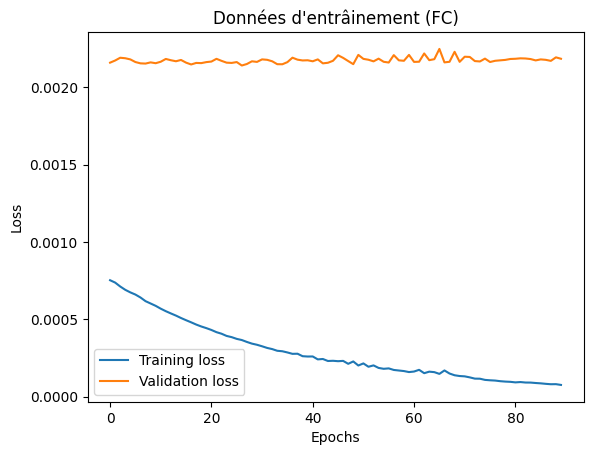

In [31]:
# Evaluer l'apprentissage d'un modèle --Code: Patrick Reuter--
def montrerCourbesApprentissage(history):
    #list all data in history
    print(history.history.keys())

    plt.plot(history.history['loss'][10:], label="Training loss")
    plt.plot(history.history['val_loss'][10:], label="Validation loss")

    plt.title("Données d'entrâinement (FC)")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()

montrerCourbesApprentissage(history)

# On enregistre le modèle

In [37]:
enco_save_path = os.path.join('modeles/', 'my_enco_vae.keras')
encoder.save(enco_save_path)


In [38]:
deco_save_path = os.path.join('modeles/', 'my_deco_vae.keras')
decoder.save(deco_save_path)

In [19]:
enco_save_path = os.path.join('modeles/', 'my_enco_vae.keras')
deco_save_path = os.path.join('modeles/', 'my_deco_vae.keras')

pre = keras.models.load_model(enco_save_path)
post = keras.models.load_model(deco_save_path)

# Prédicitions sur un pixel

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


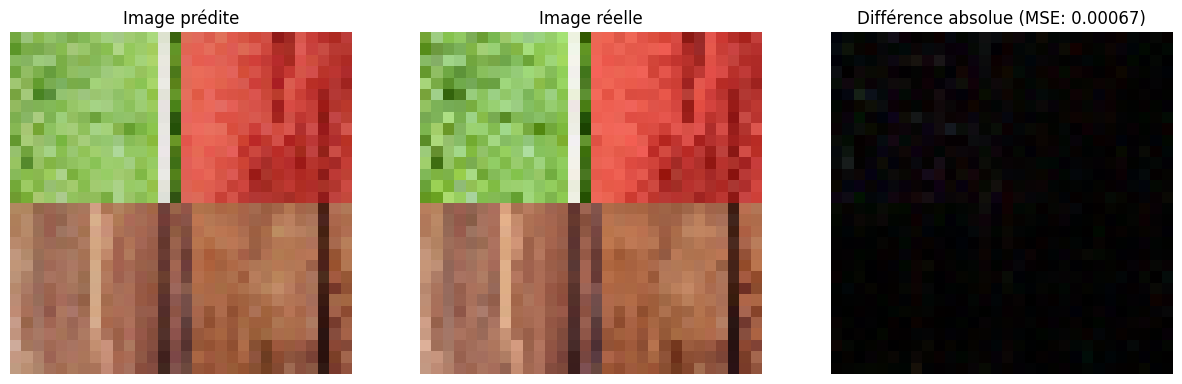

In [61]:
def show_comparaison(sample_index):
    ground_truth_image = X_train[sample_index][tf.newaxis, :] # Ajouter une dimension de batch
    original_category_one_hot = Y_train_one_hot[sample_index][tf.newaxis, :] # Ajouter une dimension de batch

    # Encoder l'image pour obtenir son vecteur latent
    z_mean, z_log_var, z_sampled = encoder.predict([ground_truth_image, original_category_one_hot])

    # On peut utiliser z_mean ou z_sampled pour la reconstruction
    z_to_decode = z_mean

    # Préparer l'entrée du décodeur pour la reconstruction
    predicted_image = decoder.predict([z_to_decode, original_category_one_hot])

    # Calcul des différences
    diff_image = np.abs(predicted_image - ground_truth_image)
    mse = np.mean(np.square(predicted_image - ground_truth_image))

    fig, axs = plt.subplots(1, 3, figsize=(15, 5))

    axs[0].imshow(predicted_image[0])
    axs[0].set_title("Image prédite")
    axs[0].axis('off')

    axs[1].imshow(ground_truth_image[0])
    axs[1].set_title("Image réelle")
    axs[1].axis('off')

    axs[2].imshow(diff_image[0])
    axs[2].set_title(f"Différence absolue (MSE: {mse:.5f})")
    axs[2].axis('off')

idx = 0
show_comparaison(idx)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


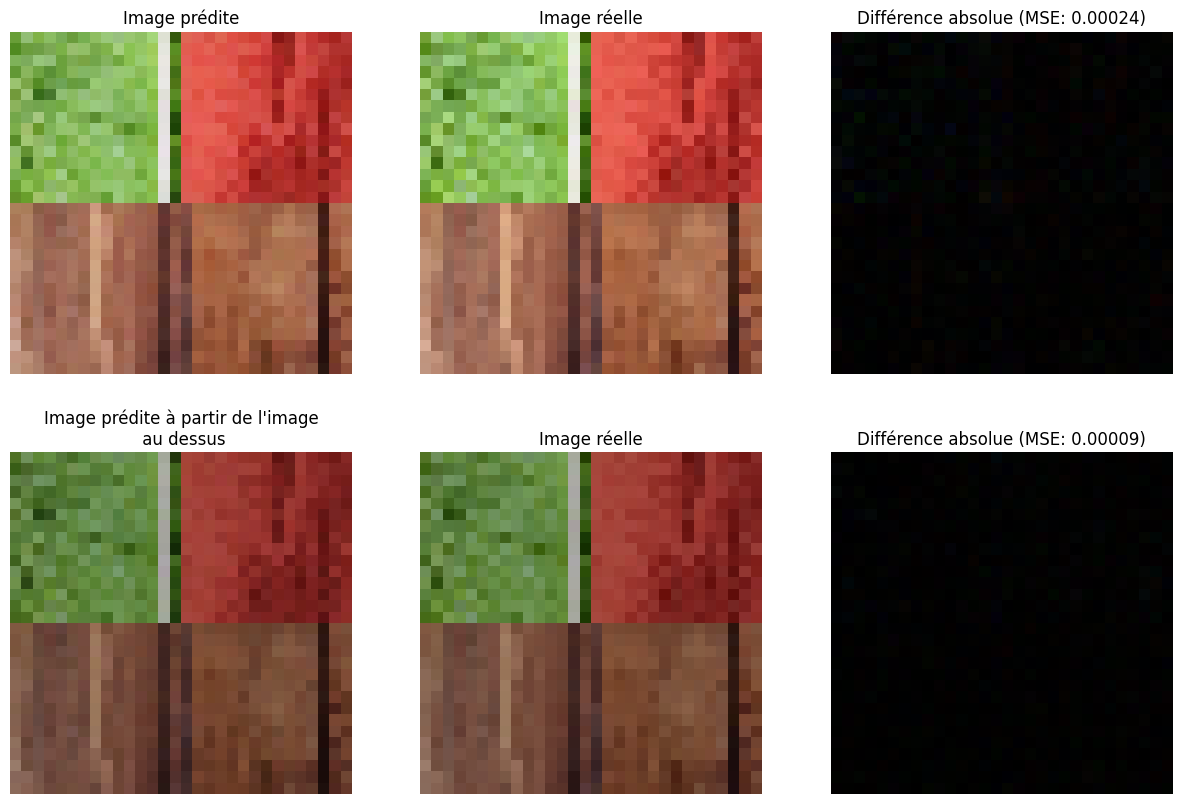

In [69]:
def show_comparaison_advanced(sample_index, conditioned_index, target_tl, target_pl):
    ground_truth_image = X_train[sample_index][tf.newaxis, :] # Ajouter une dimension de batch
    original_category_one_hot = Y_train_one_hot[sample_index][tf.newaxis, :] # Ajouter une dimension de batch

    # Encoder l'image pour obtenir son vecteur latent
    z_mean, z_log_var, z_sampled = encoder.predict([ground_truth_image, original_category_one_hot])

    # On peut utiliser z_mean ou z_sampled pour la reconstruction
    z_to_decode = z_mean

    # Préparer l'entrée du décodeur pour la reconstruction
    predicted_image = decoder.predict([z_to_decode, original_category_one_hot])

    # Calcul des différences
    diff_image = np.abs(predicted_image - ground_truth_image)
    mse = np.mean(np.square(predicted_image - ground_truth_image))

    fig, axs = plt.subplots(2, 3, figsize=(15, 10))

    axs[0, 0].imshow(predicted_image[0])
    axs[0, 0].set_title("Image prédite")
    axs[0, 0].axis('off')

    axs[0, 1].imshow(ground_truth_image[0])
    axs[0, 1].set_title("Image réelle")
    axs[0, 1].axis('off')

    axs[0, 2].imshow(diff_image[0])
    axs[0, 2].set_title(f"Différence absolue (MSE: {mse:.5f})")
    axs[0, 2].axis('off')

    # Reconstruire la même image sous une NOUVELLE condition de lumière
    if (target_tl, target_pl) in angle_to_category_map:
        new_target_category_idx = angle_to_category_map[(target_tl, target_pl)]
        new_target_category_one_hot = tf.keras.utils.to_categorical([new_target_category_idx], num_classes=N_angles_categories)
        new_target_category_one_hot_batch = new_target_category_one_hot[0][tf.newaxis, :]

        ground_truth_image_cond = X_train[conditioned_index][tf.newaxis, :] # Ajouter une dimension de batch
        conditioned_image = decoder.predict([z_to_decode, new_target_category_one_hot_batch])

        diff_image_cond = np.abs(conditioned_image - ground_truth_image_cond)
        mse_cond = np.mean(np.square(conditioned_image - ground_truth_image_cond))
        

        axs[1, 0].imshow(conditioned_image[0])
        axs[1, 0].set_title("Image prédite à partir de l'image\n au dessus")
        axs[1, 0].axis('off')

        axs[1, 1].imshow(ground_truth_image_cond[0])
        axs[1, 1].set_title("Image réelle")
        axs[1, 1].axis('off')

        axs[1, 2].imshow(diff_image_cond[0])
        axs[1, 2].set_title(f"Différence absolue (MSE: {mse_cond:.5f})")
        axs[1, 2].axis('off')

idx = 1
idx_cond = 47
tl, pl = angle_combinations[idx_cond]

# En gros, ce qu'on fait, c'est que l'on prédit une image, avec un certain angle de lumière
# Mais en utilisant le vecteur latent produit par un autre angle
show_comparaison_advanced(idx, idx_cond, tl, pl)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 

Forme des vecteurs latents (z_mean_all_images): (81, 3)


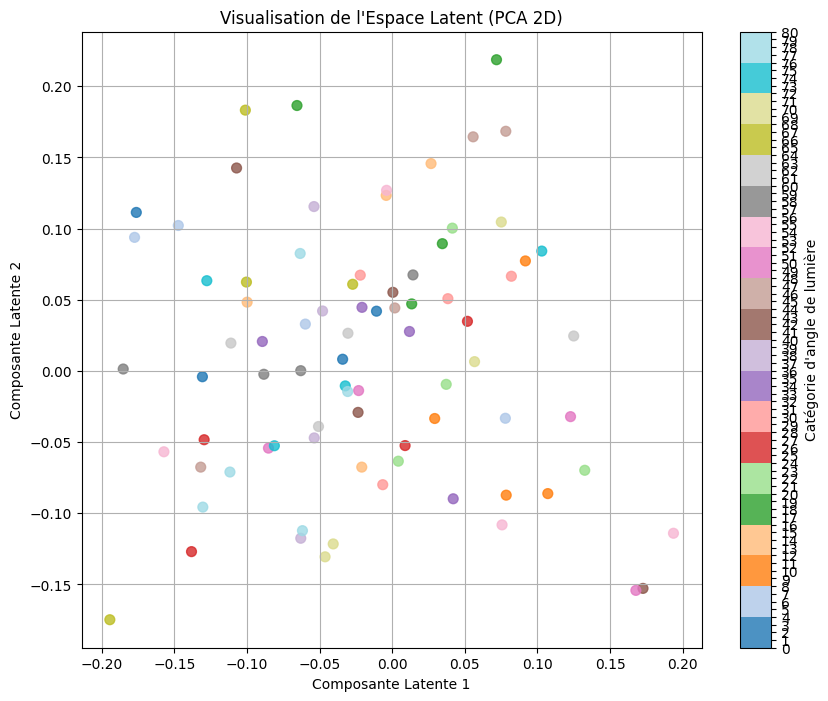

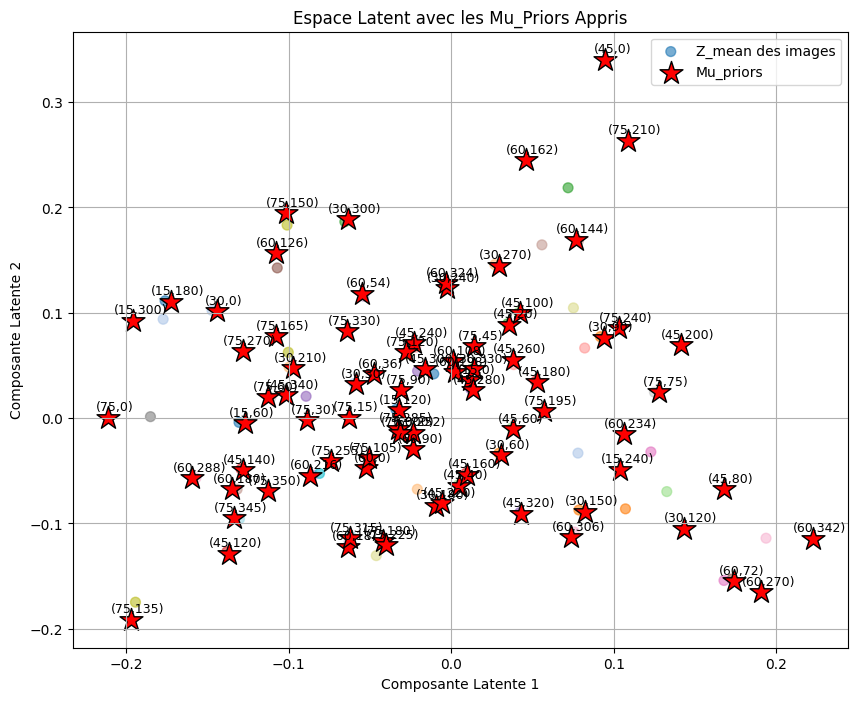

In [71]:
# --- 1. Obtenir les vecteurs latents pour toutes vos images ---
# Assurez-vous que X_train et Y_train_one_hot sont les données d'entraînement COMPLÈTES
# (avant toute division entraînement/validation si vous l'avez faite)
# sinon, utilisez les données que vous avez utilisées pour l'entraînement.

# L'encodeur prend [images, categories_one_hot] et sort [z_mean, z_log_var, z_sampled]
# Nous utilisons z_mean pour la visualisation car c'est la moyenne de la distribution apprise.
z_mean_all_images, _, _ = encoder.predict([X_train, Y_train_one_hot])

print(f"\nForme des vecteurs latents (z_mean_all_images): {z_mean_all_images.shape}") # Devrait être (nombre_images, latent_dim)

# --- 2. Obtenir les catégories d'angles originales pour la coloration ---
# Y_train_categories contient les indices numériques des catégories pour chaque image.
# C'est ce que nous utiliserons pour colorer les points sur le graphique.

# --- 3. Réduction de dimensionnalité (si latent_dim > 3) ---
# Si latent_dim est 2 ou 3, vous pouvez plotter directement.
# Si latent_dim est plus grand, nous devons le réduire pour la visualisation 2D ou 3D.

# Exemple avec t-SNE pour la visualisation 2D
# N'oubliez pas que t-SNE est stochastique, les résultats peuvent varier légèrement.
# C'est une bonne idée d'exécuter plusieurs fois ou d'utiliser un random_state fixe.
if latent_dim > 3:
    print("Réduction de dimensionnalité avec t-SNE...")
    # Pour un petit dataset, PCA peut être plus rapide et suffisant initialement.
    # tsne = TSNE(n_components=2, random_state=42, perplexity=min(30, len(z_mean_all_images)-1))
    # z_reduced = tsne.fit_transform(z_mean_all_images)

    # Utilisons PCA pour commencer, car c'est plus déterministe et souvent suffisant
    # pour une première inspection, surtout si latent_dim n'est pas énorme.
    pca = PCA(n_components=2)
    z_reduced = pca.fit_transform(z_mean_all_images)
    print(f"Forme des vecteurs latents réduits (PCA): {z_reduced.shape}")
elif latent_dim == 3:
    z_reduced = z_mean_all_images # Utiliser directement les 3 dimensions pour un plot 3D
elif latent_dim == 2:
    z_reduced = z_mean_all_images # Utiliser directement les 2 dimensions pour un plot 2D
else: # latent_dim = 1 (rare pour des VAEs)
    print("Latent dimension est trop petite pour une visualisation de 'cluster'.")
    # Dans ce cas, vous pourriez simplement faire un histogramme ou un scatter plot 1D.


# --- 4. Visualisation ---
plt.figure(figsize=(10, 8))

# Utilisez Y_train_categories pour la coloration
# Chaque point représente une image, sa couleur indique sa catégorie d'angle de lumière
scatter = plt.scatter(z_reduced[:, 0], z_reduced[:, 1], c=Y_train_categories, cmap='tab20', s=50, alpha=0.8) # 'tab20' pour plus de couleurs
plt.colorbar(scatter, ticks=range(N_angles_categories), label='Catégorie d\'angle de lumière')

# Optionnel : annoter les légendes de couleur avec les vrais (tl, pl)
# Créez une liste de labels pour la légende si N_angles_categories n'est pas trop grand
legend_labels = []
# angle_combinations est la liste des tuples (tl, pl) triés
for i, (tl, pl) in enumerate(angle_combinations):
    legend_labels.append(f'Cat {i}: ({tl}, {pl})')

# Si vous voulez une légende séparée des ticks de la colorbar, c'est plus complexe avec scatter.
# Une autre approche est d'ajouter des annotations directes si le nombre de catégories est faible.

plt.title('Visualisation de l\'Espace Latent (PCA 2D)')
plt.xlabel('Composante Latente 1')
plt.ylabel('Composante Latente 2')
plt.grid(True)
plt.show()

# --- Visualisation des mu_priors (dans le même espace si réduit) ---
# Les mu_priors sont des points dans l'espace latent de dimension 'latent_dim'.
# Pour les visualiser sur le même graphique 2D/3D que z_reduced, ils doivent être réduits de la même manière.
if latent_dim > 3:
    mu_priors_reduced = pca.transform(clvae_model.mu_priors.numpy())
elif latent_dim == 3 or latent_dim == 2:
    mu_priors_reduced = clvae_model.mu_priors.numpy()
else:
    mu_priors_reduced = None # Pas de visualisation pertinente si latent_dim est 1


if mu_priors_reduced is not None:
    plt.figure(figsize=(10, 8))
    # Plot des points z_mean
    plt.scatter(z_reduced[:, 0], z_reduced[:, 1], c=Y_train_categories, cmap='tab20', s=50, alpha=0.6, label='Z_mean des images')

    # Plot des mu_priors (souvent en forme d'étoile ou de marqueur distinct)
    plt.scatter(mu_priors_reduced[:, 0], mu_priors_reduced[:, 1],
                marker='*', s=300, c='red', edgecolors='black', label='Mu_priors') # Grandes étoiles rouges

    # Optionnel : annoter chaque mu_prior avec sa catégorie
    for i, (tl, pl) in enumerate(angle_combinations):
        plt.annotate(f'({tl},{pl})', (mu_priors_reduced[i, 0], mu_priors_reduced[i, 1]),
                     textcoords="offset points", xytext=(5,5), ha='center', fontsize=9)

    plt.title('Espace Latent avec les Mu_Priors Appris')
    plt.xlabel('Composante Latente 1')
    plt.ylabel('Composante Latente 2')
    plt.legend()
    plt.grid(True)
    plt.show()


Obtention des vecteurs latents (z_mean) pour la visualisation...
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
Forme des vecteurs latents (z_mean_all_images): (81, 3)

Génération de la visualisation 3D (colorée par TL)...


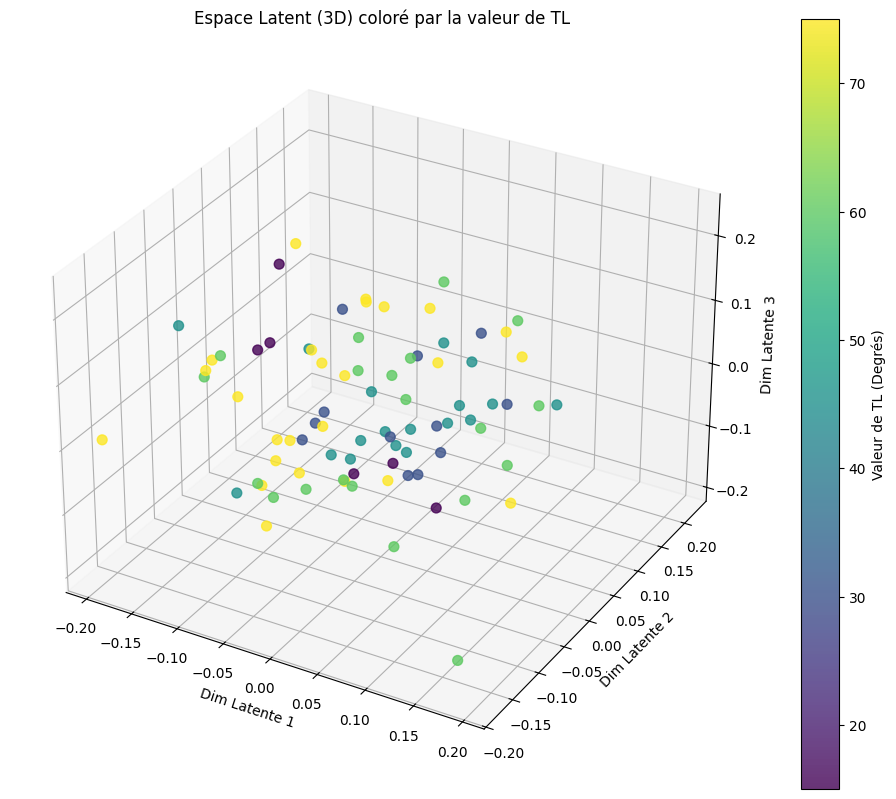


Génération de la visualisation 3D (colorée par PL)...


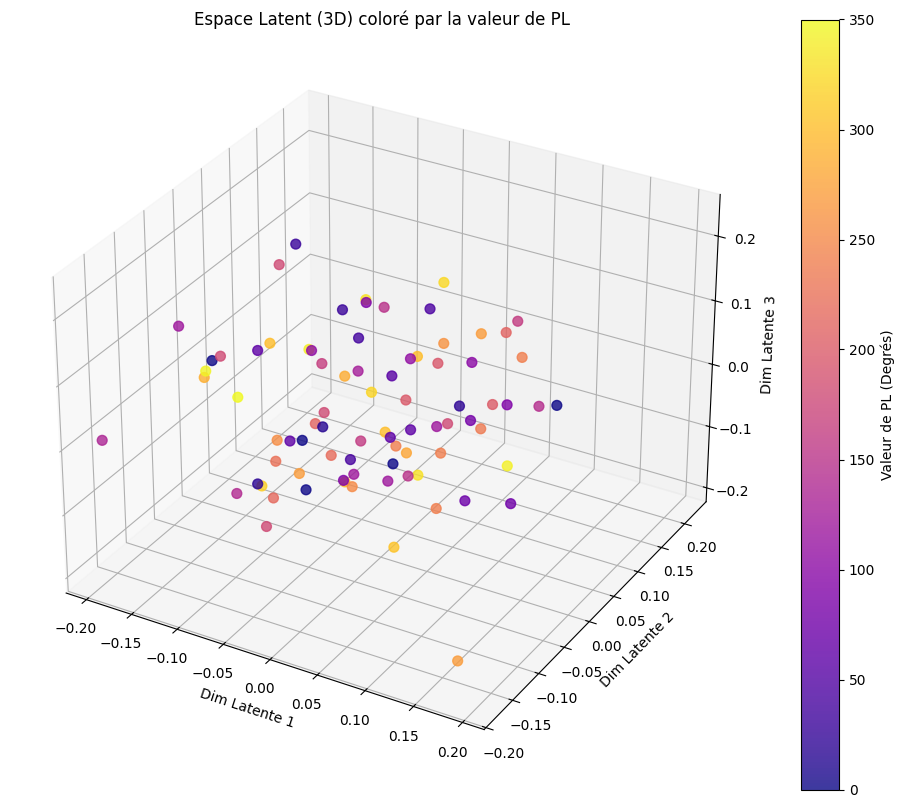


Visualisation des Mu_Priors dans l'espace latent (optionnel)...


<Figure size 1000x800 with 0 Axes>

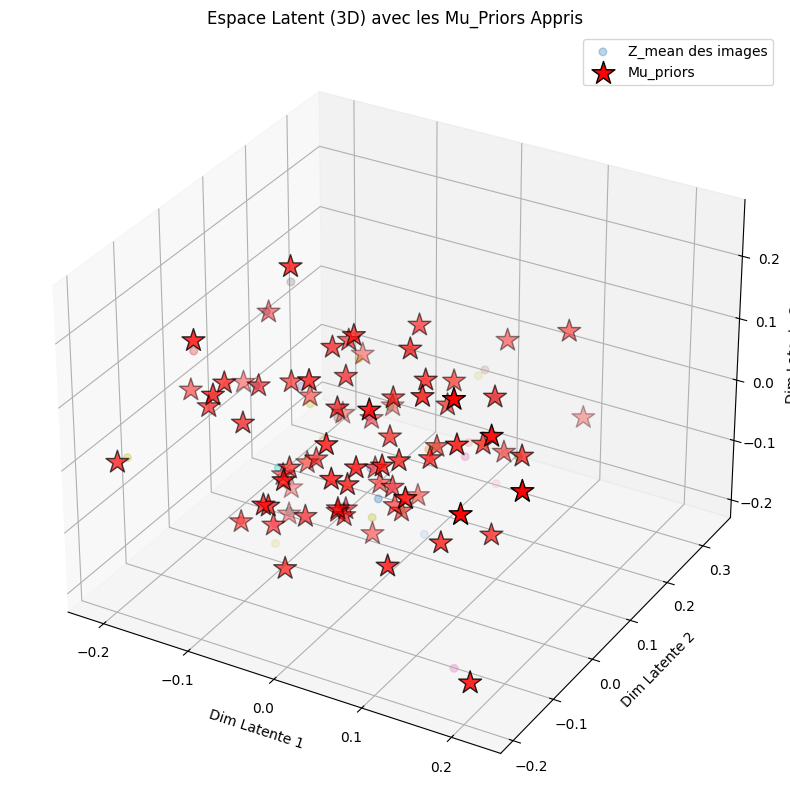

In [72]:
# --- Obtention des vecteurs latents pour la visualisation ---
if len(X_train) > 0:
    print("\nObtention des vecteurs latents (z_mean) pour la visualisation...")
    z_mean_all_images, _, _ = encoder.predict([X_train, Y_train_one_hot])
    print(f"Forme des vecteurs latents (z_mean_all_images): {z_mean_all_images.shape}")

    # Extraire les valeurs tl et pl pour chaque image
    tl_values = np.array([info["tl"] for info in images_info])
    pl_values = np.array([info["pl"] for info in images_info])

    # --- Visualisation 3D : colorer par tl ---
    print("\nGénération de la visualisation 3D (colorée par TL)...")
    fig = plt.figure(figsize=(12, 10))
    ax = fig.add_subplot(111, projection='3d')

    scatter = ax.scatter(
        z_mean_all_images[:, 0],
        z_mean_all_images[:, 1],
        z_mean_all_images[:, 2],
        c=tl_values,
        cmap='viridis',
        s=50,
        alpha=0.8
    )

    ax.set_title('Espace Latent (3D) coloré par la valeur de TL')
    ax.set_xlabel('Dim Latente 1')
    ax.set_ylabel('Dim Latente 2')
    ax.set_zlabel('Dim Latente 3')
    fig.colorbar(scatter, ax=ax, label='Valeur de TL (Degrés)')
    plt.show()

    # --- Visualisation 3D : colorer par pl ---
    print("\nGénération de la visualisation 3D (colorée par PL)...")
    fig = plt.figure(figsize=(12, 10))
    ax = fig.add_subplot(111, projection='3d')

    scatter = ax.scatter(
        z_mean_all_images[:, 0],
        z_mean_all_images[:, 1],
        z_mean_all_images[:, 2],
        c=pl_values,
        cmap='plasma',
        s=50,
        alpha=0.8
    )

    ax.set_title('Espace Latent (3D) coloré par la valeur de PL')
    ax.set_xlabel('Dim Latente 1')
    ax.set_ylabel('Dim Latente 2')
    ax.set_zlabel('Dim Latente 3')
    fig.colorbar(scatter, ax=ax, label='Valeur de PL (Degrés)')
    plt.show()

    # --- Visualisation des mu_priors (Optionnel, utile après entraînement plus long) ---
    # Cette partie est plus pertinente après un entraînement plus long où les priors ont convergé.
    # Pour l'exemple, nous l'incluons, mais les positions peuvent ne pas être très "clusterisées"
    # avec seulement 10 époques.
    print("\nVisualisation des Mu_Priors dans l'espace latent (optionnel)...")
    mu_priors_np = clvae_model.mu_priors.numpy()

    plt.figure(figsize=(10, 8))
    ax = plt.figure(figsize=(12, 10)).add_subplot(111, projection='3d')

    # Plot des points z_mean (en arrière-plan, plus transparent)
    ax.scatter(z_mean_all_images[:, 0], z_mean_all_images[:, 1], z_mean_all_images[:, 2],
               c=Y_train_categories, cmap='tab20', s=30, alpha=0.3, label='Z_mean des images')

    # Plot des mu_priors (points plus grands, plus visibles)
    ax.scatter(mu_priors_np[:, 0], mu_priors_np[:, 1], mu_priors_np[:, 2],
               marker='*', s=300, c='red', edgecolors='black', label='Mu_priors')

    ax.set_title('Espace Latent (3D) avec les Mu_Priors Appris')
    ax.set_xlabel('Dim Latente 1')
    ax.set_ylabel('Dim Latente 2')
    ax.set_zlabel('Dim Latente 3')
    plt.legend()
    plt.show()

else:
    print("C'est choww")

In [84]:
# --- Obtention des vecteurs latents pour la visualisation ---
print("\nObtention des vecteurs latents (z_mean) pour la visualisation...")
z_mean_all_images, _, _ = encoder.predict([X_train, Y_train_one_hot])
print(f"Forme des vecteurs latents (z_mean_all_images): {z_mean_all_images.shape}")


# --- Fonction pour créer et enregistrer l'animation 3D ---
def animate_latent_space_3d(z_data, color_by='tl', rotation_speed=1.5, interval_ms=50, filename=None):
    """
    Crée un graphique scatter 3D animé de l'espace latent et l'enregistre en tant que vidéo.

    Args:
        z_data (np.array): Les données 3D de l'espace latent (z_mean_all_images).
        color_by (str): 'tl' pour colorer par TL, 'pl' pour colorer par PL.
        rotation_speed (float): Vitesse de rotation (degrés par frame).
        interval_ms (int): Délai entre les frames en millisecondes.
        filename (str): Nom du fichier de sortie de la vidéo (ex: 'animation_tl.mp4').
                        Si None, l'animation ne sera pas enregistrée.
    """
    if z_data.shape[1] != 3:
        print(f"Erreur: z_data doit avoir 3 dimensions pour le plot 3D. Forme actuelle: {z_data.shape}")
        return

    # Sélection des données de couleur et des labels basés sur le paramètre color_by
    if color_by == 'tl':
        color_values = tl_values # tl_values doit être disponible ici
        cmap_name = 'viridis'
        label_cbar = 'Valeur de TL (Degrés)'
        title_suffix = 'coloré par la valeur de TL'
    elif color_by == 'pl':
        color_values = pl_values # pl_values doit être disponible ici
        cmap_name = 'plasma'
        label_cbar = 'Valeur de PL (Degrés)'
        title_suffix = 'coloré par la valeur de PL'
    else:
        print("Paramètre 'color_by' invalide. Choisissez 'tl' ou 'pl'.")
        return

    fig = plt.figure(figsize=(12, 10))
    ax = fig.add_subplot(111, projection='3d')

    scatter = ax.scatter(
        z_data[:, 0],
        z_data[:, 1],
        z_data[:, 2],
        c=color_values,
        cmap=cmap_name,
        s=50,
        alpha=0.8
    )

    ax.set_title(f'Espace Latent (3D) animé {title_suffix}')
    ax.set_xlabel('Dim Latente 1')
    ax.set_ylabel('Dim Latente 2')
    ax.set_zlabel('Dim Latente 3')
    fig.colorbar(scatter, ax=ax, label=label_cbar)

    # Fonction de mise à jour pour l'animation
    def update(frame):
        ax.view_init(elev=30 + frame * rotation_speed * 0.1, azim=frame * rotation_speed)
        return scatter,

    # Crée l'animation
    ani = FuncAnimation(fig, update, frames=np.arange(0, 360 / rotation_speed * 5, 1),
                        interval=interval_ms, blit=False)

    # --- ENREGISTRE L'ANIMATION EN TANT QUE VIDÉO ---
    if filename:
        print(f"Enregistrement de l'animation vers {filename}...")
        try:
            writer = 'ffmpeg' # Par défaut pour .mp4
            if filename.lower().endswith('.gif'):
                writer = 'pillow' # Utilise pillow pour les GIFs

            ani.save(filename, writer=writer, fps=20) # fps=20 frames par seconde
            print(f"Animation enregistrée avec succès sous {filename}")
        except Exception as e:
            print(f"Erreur lors de l'enregistrement de l'animation: {e}")
            print(f"Assurez-vous que '{writer}' est installé et accessible via votre PATH.")
            if writer == 'ffmpeg':
                print("Pour installer ffmpeg: https://ffmpeg.org/download.html (suivez les instructions pour votre OS)")
            elif writer == 'pillow':
                print("Pour installer pillow: pip install Pillow")
    
    plt.close(fig) # Ferme la figure pour libérer la mémoire, car elle ne s'affiche pas en direct.

# --- Appel de la fonction d'animation ---
# Vous pouvez choisir la coloration ici ('tl' ou 'pl') et le nom du fichier de sortie.

# Animation colorée par TL
print("\nLancement de la création de l'animation (TL)...")
animate_latent_space_3d(z_mean_all_images, color_by='tl', rotation_speed=2, filename='latent_space_tl.mp4')

# Animation colorée par PL
print("\nLancement de la création de l'animation (PL)...")
animate_latent_space_3d(z_mean_all_images, color_by='pl', rotation_speed=2, filename='latent_space_pl.mp4')

# --- Visualisation des mu_priors (Optionnel, reste statique car l'animation est plus complexe ici) ---
# Si vous voulez l'animer, il faudrait l'intégrer dans une fonction similaire.
if 'clvae_model' in locals():
    print("\nVisualisation des Mu_Priors dans l'espace latent (statique)...")
    mu_priors_np = clvae_model.mu_priors.numpy()

    fig = plt.figure(figsize=(12, 10))
    ax = fig.add_subplot(111, projection='3d')

    ax.scatter(z_mean_all_images[:, 0], z_mean_all_images[:, 1], z_mean_all_images[:, 2],
               c=Y_train_categories, cmap='tab20', s=30, alpha=0.3, label='Z_mean des images')

    ax.scatter(mu_priors_np[:, 0], mu_priors_np[:, 1], mu_priors_np[:, 2],
               marker='*', s=300, c='red', edgecolors='black', label='Mu_priors')

    ax.set_title('Espace Latent (3D) avec les Mu_Priors Appris')
    ax.set_xlabel('Dim Latente 1')
    ax.set_ylabel('Dim Latente 2')
    ax.set_zlabel('Dim Latente 3')
    plt.legend()
    plt.show() # Pour cette figure statique, on utilise plt.show()
else:
    print("La variable 'clvae_model' n'est pas définie. Impossible de visualiser les Mu_Priors.")



Obtention des vecteurs latents (z_mean) pour la visualisation...
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Forme des vecteurs latents (z_mean_all_images): (81, 3)

Lancement de la création de l'animation (TL)...


<IPython.core.display.Javascript object>

Enregistrement de l'animation vers latent_space_tl.mp4...
Animation enregistrée avec succès sous latent_space_tl.mp4


/Users/sebych/miniforge3/envs/MLStuff/lib/python3.12/site-packages/matplotlib/animation.py:908: UserWarning: Animation was deleted without rendering anything. This is most likely not intended. To prevent deletion, assign the Animation to a variable, e.g. `anim`, that exists until you output the Animation using `plt.show()` or `anim.save()`.
  warnings.warn(


AttributeError: 'NoneType' object has no attribute 'remove_callback'

In [87]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import FuncAnimation

if 'z_mean_all_images' not in locals() or z_mean_all_images.shape[0] == 0:
    print("Erreur: 'z_mean_all_images' n'est pas défini ou est vide. Exécutez les étapes précédentes.")
    exit()
if 'tl_values' not in locals():
    print("Erreur: 'tl_values' n'est pas défini. Exécutez les étapes précédentes de chargement de données.")
    exit()
if z_mean_all_images.shape[1] != 3:
    print(f"Erreur: z_mean_all_images doit avoir 3 dimensions pour le plot 3D. Forme actuelle: {z_mean_all_images.shape}")
    exit()
# -----------------------------------------------------------------------------

print("Lancement de la création et de l'enregistrement de l'animation (TL)...")

# Paramètres de l'animation
rotation_speed = 2 # Degrés par frame
interval_ms = 50   # Millisecondes entre les frames (50ms = 20 fps)
output_filename = 'latent_space_tl.mp4'

fig_tl = plt.figure(figsize=(12, 10))
ax_tl = fig_tl.add_subplot(111, projection='3d')

scatter_tl = ax_tl.scatter(
    z_mean_all_images[:, 0],
    z_mean_all_images[:, 1],
    z_mean_all_images[:, 2],
    c=tl_values,
    cmap='viridis',
    s=50,
    alpha=0.8
)

ax_tl.set_title('Espace Latent (3D) animé coloré par la valeur de TL')
ax_tl.set_xlabel('Dim Latente 1')
ax_tl.set_ylabel('Dim Latente 2')
ax_tl.set_zlabel('Dim Latente 3')
fig_tl.colorbar(scatter_tl, ax=ax_tl, label='Valeur de TL (Degrés)')

def update_tl(frame):
    ax_tl.view_init(elev=30 + frame * rotation_speed * 0.1, azim=frame * rotation_speed)
    return scatter_tl,

ani_tl = FuncAnimation(fig_tl, update_tl, frames=np.arange(0, 360 / rotation_speed * 5, 1),
                       interval=interval_ms, blit=False)

print(f"Enregistrement de l'animation TL vers {output_filename}...")
try:
    ani_tl.save(output_filename, writer='ffmpeg', fps=20)
    print(f"Animation TL enregistrée avec succès sous {output_filename}")
except Exception as e:
    print(f"Erreur lors de l'enregistrement de l'animation TL: {e}")
    print("Assurez-vous que 'ffmpeg' est installé et accessible via votre PATH.")
    print("Pour installer ffmpeg: https://ffmpeg.org/download.html (suivez les instructions pour votre OS)")
finally:
    # Nettoyer l'objet animation explicitement
    if hasattr(ani_tl, 'event_source') and ani_tl.event_source is not None:
        ani_tl.event_source.stop()
        ani_tl.event_source = None
    del ani_tl
    plt.close(fig_tl) # Ferme la figure après l'enregistrement

Lancement de la création et de l'enregistrement de l'animation (TL)...


<IPython.core.display.Javascript object>

Enregistrement de l'animation TL vers latent_space_tl.mp4...
Animation TL enregistrée avec succès sous latent_space_tl.mp4


AttributeError: 'NoneType' object has no attribute 'remove_callback'

In [88]:
if 'z_mean_all_images' not in locals() or z_mean_all_images.shape[0] == 0:
    print("Erreur: 'z_mean_all_images' n'est pas défini ou est vide. Exécutez les étapes précédentes.")
    exit()
if 'pl_values' not in locals():
    print("Erreur: 'pl_values' n'est pas défini. Exécutez les étapes précédentes de chargement de données.")
    exit()
if z_mean_all_images.shape[1] != 3:
    print(f"Erreur: z_mean_all_images doit avoir 3 dimensions pour le plot 3D. Forme actuelle: {z_mean_all_images.shape}")
    exit()
# -----------------------------------------------------------------------------

print("\nLancement de la création et de l'enregistrement de l'animation (PL)...")

# Paramètres de l'animation
rotation_speed = 2 # Degrés par frame
interval_ms = 50   # Millisecondes entre les frames (50ms = 20 fps)
output_filename = 'latent_space_pl.mp4'

fig_pl = plt.figure(figsize=(12, 10))
ax_pl = fig_pl.add_subplot(111, projection='3d')

scatter_pl = ax_pl.scatter(
    z_mean_all_images[:, 0],
    z_mean_all_images[:, 1],
    z_mean_all_images[:, 2],
    c=pl_values,
    cmap='plasma',
    s=50,
    alpha=0.8
)

ax_pl.set_title('Espace Latent (3D) animé coloré par la valeur de PL')
ax_pl.set_xlabel('Dim Latente 1')
ax_pl.set_ylabel('Dim Latente 2')
ax_pl.set_zlabel('Dim Latente 3')
fig_pl.colorbar(scatter_pl, ax=ax_pl, label='Valeur de PL (Degrés)')

def update_pl(frame):
    ax_pl.view_init(elev=30 + frame * rotation_speed * 0.1, azim=frame * rotation_speed)
    return scatter_pl,

ani_pl = FuncAnimation(fig_pl, update_pl, frames=np.arange(0, 360 / rotation_speed * 5, 1),
                       interval=interval_ms, blit=False)

print(f"Enregistrement de l'animation PL vers {output_filename}...")
try:
    ani_pl.save(output_filename, writer='ffmpeg', fps=20)
    print(f"Animation PL enregistrée avec succès sous {output_filename}")
except Exception as e:
    print(f"Erreur lors de l'enregistrement de l'animation PL: {e}")
finally:
    # Nettoyer l'objet animation explicitement
    if hasattr(ani_pl, 'event_source') and ani_pl.event_source is not None:
        ani_pl.event_source.stop()
        ani_pl.event_source = None
    del ani_pl
    plt.close(fig_pl) # Ferme la figure après l'enregistrement


Lancement de la création et de l'enregistrement de l'animation (PL)...


<IPython.core.display.Javascript object>

Enregistrement de l'animation PL vers latent_space_pl.mp4...
Animation PL enregistrée avec succès sous latent_space_pl.mp4


AttributeError: 'NoneType' object has no attribute 'remove_callback'

In [92]:
# Vérifications préliminaires : Assurez-vous que ces variables existent
if 'z_mean_all_images' not in locals() or z_mean_all_images.shape[0] == 0:
    print("Erreur: 'z_mean_all_images' n'est pas défini ou est vide. Exécutez les étapes précédentes.")
    exit()
if 'tl_values' not in locals() or 'pl_values' not in locals():
    print("Erreur: 'tl_values' ou 'pl_values' ne sont pas définis. Exécutez les étapes précédentes de chargement de données.")
    exit()
if z_mean_all_images.shape[1] != 3:
    print(f"Erreur: z_mean_all_images doit avoir 3 dimensions pour le plot 3D. Forme actuelle: {z_mean_all_images.shape}")
    exit()
# -----------------------------------------------------------------------------

print("\nLancement de la création et de l'enregistrement de l'animation (coloration par somme TL+PL)...")

# Paramètres de l'animation
rotation_speed = 2 # Degrés par frame
interval_ms = 50   # Millisecondes entre les frames (50ms = 20 fps)
output_filename = 'latent_space_tl_plus_pl_sum.mp4'

# NOUVEAU: Création de la valeur de couleur basée sur la somme des angles
color_sum_values = tl_values + pl_values
# -----------------------------------------------------------------------------

fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

# Utilisation de la somme des angles pour la coloration
# 'viridis' est une excellente carte de couleurs, perceptuellement uniforme et adaptée aux données continues.
cmap_name = 'viridis' 

scatter = ax.scatter(
    z_mean_all_images[:, 0],
    z_mean_all_images[:, 1],
    z_mean_all_images[:, 2],
    c=color_sum_values, # Coloration par la somme des angles TL + PL
    cmap=cmap_name,
    s=50,
    alpha=0.8
)

ax.set_title('Espace Latent (3D) animé coloré par la somme de TL et PL')
ax.set_xlabel('Dim Latente 1')
ax.set_ylabel('Dim Latente 2')
ax.set_zlabel('Dim Latente 3')
# La barre de couleurs indique la plage de valeurs de la somme des angles (min TL+PL à max TL+PL)
fig.colorbar(scatter, ax=ax, label='Somme des angles TL + PL (Degrés)')

def update(frame):
    # La vue tourne pour animer le graphique
    ax.view_init(elev=30 + frame * rotation_speed * 0.1, azim=frame * rotation_speed)
    return scatter, # Retourne l'objet scatter mis à jour pour l'animation

# Crée l'animation
ani = FuncAnimation(fig, update, frames=np.arange(0, 360 / rotation_speed * 5, 1),
                       interval=interval_ms, blit=False) # blit=False est plus robuste pour les plots 3D

print(f"Enregistrement de l'animation colorée par somme TL+PL vers {output_filename}...")
try:
    # Tente d'enregistrer l'animation en MP4 (nécessite FFmpeg)
    ani.save(output_filename, writer='ffmpeg', fps=20) 
    print(f"Animation colorée par somme TL+PL enregistrée avec succès sous {output_filename}")
except Exception as e:
    print(f"Erreur lors de l'enregistrement de l'animation colorée par somme TL+PL: {e}")
finally:
    # Nettoyage explicite de l'objet animation pour éviter les erreurs futures
    if hasattr(ani, 'event_source') and ani.event_source is not None:
        ani.event_source.stop() # Arrête les événements de l'animation
        ani.event_source = None # Réinitialise explicitement à None pour éviter les problèmes d'accès
    del ani # Supprime la référence à l'objet animation
    plt.close(fig) # Ferme la figure pour libérer la mémoire.


Lancement de la création et de l'enregistrement de l'animation (coloration par somme TL+PL)...


<IPython.core.display.Javascript object>

Enregistrement de l'animation colorée par somme TL+PL vers latent_space_tl_plus_pl_sum.mp4...
Animation colorée par somme TL+PL enregistrée avec succès sous latent_space_tl_plus_pl_sum.mp4


AttributeError: 'NoneType' object has no attribute 'remove_callback'